In [0]:
!pip install slycot
!pip install control

In [0]:
from IPython.display import Math, HTML
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
               "latest.js?config=default'></script>"))

# What is control theory?

Control theory allows us to leverage everything we know about a system to get the dynamics that we want.

There are lots of subdivisions within control theory, including passive control, active open-loop control, and active feedback (closed-loop) control. We'll focus on closed-loop control.


The premise of control theory is that you know the dynamics of your system:
for a state x, with input u and output y we have: 

<img src=https://www.cds.caltech.edu/~murray/amwiki/extensions/wikitex/tmp/14378c274dddaa1de2c32860716a059b1.png>

$A\in R^{n\times n}$ gives dynamics, 

$B \in R^{n\times p}$ is the control scheme, 

C is the measurement conversion, and 

D is a feedback term.



## Essential topics

### Stability
Does our system blow up? Or will it acheive a nice, steady state?

The critical feature is the eigenvalues of the dynamics matrix, A.

The system is stable iff Re(eig(A)) are negative.

Eigenvalues determine dominant behavior.

The real part determins the sign of the exponential.

We can control this with state feedback!



### Controllability
Let's add control. Assume can measure the full state. 
Suppose we've been handed some robot with known dynamics and fixed motors and knobs. How can we know if the control is sufficient? Or can we prove that there's absolutely no way to achieve the desired effect?

We need to know that every dimension of the system can be "touched" by the control. 

To do so, we need to look at the so-called controllability matrix:

<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/4066bb07332108ab276e27181720ab040059f4ca>

Let's check controllability of a simple system.

In [0]:
import numpy as np
import control

In [0]:
# Parameters defining the system
m = 250.0  # system mass
k = 40.0   # spring constant
b = 60.0   # damping constant

# System matrices
A = np.array([[1, -1, 1.],
             [1, -k/m, -b/m],
             [1, 1, 1]])

B = np.array([[0], ## change these values to see what breaks controllability!
             [1/m],
             [1]])

## check controllability
controllability = control.ctrb(A, B)

print("Controllability matrix: \n",controllability)
rank = np.linalg.matrix_rank(controllability)
print("rank:", rank)
print("A is controllable:", rank==3)


Controllability matrix: 
 [[ 0.         0.996      2.24064  ]
 [ 0.004     -0.24064    0.7935424]
 [ 1.         1.004      1.75936  ]]
rank: 3
A is controllable: True


There's a bit more power still to be had in this analysis.
We can get more than the binary "yes" or "no" for controllability, but we can identify which dimensions are most controllable.

Taking the Singular Value Decomposition (SVD) of the controllability matrix gives ranked eigenvectors along which the system is most controllable. 

### Observability
Given less information than the full-state, will we still be able to see effects of each variable?

This has the same feel as controllability. Consider the rank of the matrix:

<img src=https://www.cds.caltech.edu/~murray/amwiki/extensions/wikitex/tmp/2ed36e64cf5dd9299e95ddd8e018159f1.png>

If W0 has full rank then eventually, we'll "see" all the variables. 

In [0]:
C = np.array([[1., 0, 1.]])

observability = control.obsv(A, C)

rank_ob = np.linalg.matrix_rank(controllability)
print("rank:", rank_ob)
print("A is observable:", rank==3)

rank: 3
A is observable: True


## Linear Quadratic Regulator (LQR)

Let's take a step back and remember our original goal:
<img src = https://www.researchgate.net/profile/Lanre_Olatomiwa/publication/280599178/figure/fig3/AS:284520810074116@1444846455596/General-block-diagram-of-full-state-feedback-controller.png>

We want to design a feedback procedure, called gain matrix K, to get to a target state.

$\dot{x} = Ax + Bu$

Let $u = -Kx$ for full state feedback $\rightarrow$

$\dot{x} = (A- BK)x$

 
 We have some state in mind that we're targeting, and we want our evolution to reach that state. 
 We need to be able to identify the K which gives us eigenvalues which acheive our state.
 
We'll construct a cost-function which defines the process of our minimization:

<img src = https://www.cds.caltech.edu/~murray/amwiki/extensions/wikitex/tmp/c70b1264082e33a356ac0dd678c08abf1.png>


It turns out there is an **analytically ideal** $K_{ideal}$  to get the eigenvalues to acheive our target state.  

### LQR for rocket science
Let's build a controller to shoot our rockets right on target!


It can't be a physics event without force body diagrams...

<img src=http://www.cds.caltech.edu/~murray/wiki/images/7/7d/Pvtol-diagram.png>  


The dynamics are put into matrix form:

<img src=http://www.cds.caltech.edu/~murray/wiki/images/2/21/Pvtol-statespace.png>

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt  # MATLAB plotting functions
import control.matlab as ctrl  # MATLAB-like functions

In [0]:
#
# System dynamics
#
# These are the dynamics for the Planar vertical TakeOff and Landing (PVTOL)
# system, written in state space form.
#


# System parameters
m = 4       # mass of aircraft
J = 0.0475  # inertia around pitch axis
r = 0.25    # distance to center of force
g = 9.8     # gravitational constant
c = 0.05    # damping factor 

# State space dynamics
xe = [0, 0, 0, 0, 0, 0]  # equilibrium point of interest
# basis: x, y, theta, xdot, ydot, thetaDot
ue = [0, m*g]  # (note these are lists, not matrices)

# Dynamics matrix (use matrix type so that * works for multiplication)
A = np.matrix(
    [[0, 0, 0, 1, 0, 0],
     [0, 0, 0, 0, 1, 0],
     [0, 0, 0, 0, 0, 1],
     [0, 0, (-ue[0]*np.sin(xe[2]) - ue[1]*np.cos(xe[2]))/m, -c/m, 0, 0],
     [0, 0, (ue[0]*np.cos(xe[2]) - ue[1]*np.sin(xe[2]))/m, 0, -c/m, 0],
     [0, 0, 0, 0, 0, 0]]
)

# Input matrix
B = np.matrix(
    [[0, 0], [0, 0], [0, 0],
     [np.cos(xe[2])/m, -np.sin(xe[2])/m],
     [np.sin(xe[2])/m, np.cos(xe[2])/m],
     [r/J, 0]]
)

# Output matrix 
C = np.matrix([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
D = np.matrix([[0, 0], [0, 0]])



In [0]:
#
# Construct inputs and outputs corresponding to steps in xy position
#
# The vectors xd and yd correspond to the states that are the desired
# equilibrium states for the system.  The matrices Cx and Cy are the 
# corresponding outputs.
#
# The way these vectors are used is to compute the closed loop system
# dynamics as
#
#   xdot = Ax + B u  =>  xdot = (A-BK)x + K xd
#      u = -K(x - xd)       y = Cx
#
# The closed loop dynamics can be simulated using the "step" command, 
# with K*xd as the input vector (assumes that the "input" is unit size,
# so that xd corresponds to the desired steady state.
#

xd = np.matrix([[1], [0], [0], [0], [0], [0]])
yd = np.matrix([[0], [1], [0], [0], [0], [0]])


# Extract the relevant dynamics for use with Single Input Single Output (SISO) library
#
# The current python-control library only supports SISO transfer
# functions, so we have to modify some parts of the original MATLAB
# code to extract out SISO systems.  To do this, we define the 'lat' and
# 'alt' index vectors to consist of the states that are are relevant
# to the lateral (x) and vertical (y) dynamics.
#

# Indices for the parts of the state that we want
lat = (0, 2, 3, 5)
alt = (1, 4)

# Decoupled dynamics
Ax = (A[lat, :])[:, lat]  # get "lat" columns and rows
Bx = B[lat, 0]
Cx = C[0, lat]
Dx = D[0, 0]

Ay = (A[alt, :])[:, alt]  # get "alt" columns and rows
By = B[alt, 1]
Cy = C[1, alt]
Dy = D[1, 1]

# Label the plot
plt.clf()
plt.suptitle("LQR controllers for vectored thrust aircraft (pvtol-lqr)")


Text(0.5, 0.98, 'LQR controllers for vectored thrust aircraft (pvtol-lqr)')

<Figure size 432x288 with 0 Axes>

In [0]:
#
# LQR design
#

# Design 1. Start with a diagonal weighting
Qx1 = np.diag([0.1, 10, 1, 1, 1, 1])
Qu1a = np.diag([1, 1])
K, X, E = ctrl.lqr(A, B, Qx1, Qu1a)
K_1 = np.matrix(K)

print("Q for xs:\n",Qx1)
print("Q for us:\n",Qu1a)
with np.printoptions(precision=3,suppress=True):
  print("OUTPUT (gain (K) matrix):\n",K_1)

Q for xs:
 [[ 0.1  0.   0.   0.   0.   0. ]
 [ 0.  10.   0.   0.   0.   0. ]
 [ 0.   0.   1.   0.   0.   0. ]
 [ 0.   0.   0.   1.   0.   0. ]
 [ 0.   0.   0.   0.   1.   0. ]
 [ 0.   0.   0.   0.   0.   1. ]]
Q for us:
 [[1 0]
 [0 1]]
OUTPUT (gain (K) matrix):
 [[-0.316  0.     6.697 -1.189  0.     1.938]
 [-0.     3.162  0.    -0.     5.078  0.   ]]


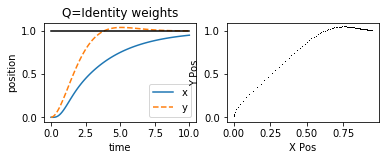

In [0]:
# Step response for the first input
sys_1_x = ctrl.ss(Ax - Bx*K_1[0, lat], Bx*K_1[0, lat]*xd[lat, :], Cx, Dx)
xs_1, time_x = ctrl.step(sys_1_x, T=np.linspace(0, 10, 100))

# Step response for the second input
sys_1_y =ctrl.ss(Ay - By*K_1[1, alt], By*K_1[1, alt]*yd[alt, :], Cy, Dy)
ys_1, time_y = ctrl.step(sys_1_y, T=np.linspace(0, 10, 100))

plt.subplot(221)
plt.title("Q=Identity weights")
# plt.plot(T, Y[:,1, 1], '-', T, Y[:,2, 2], '--')
plt.plot(time_x.T, xs_1.T, '-', time_y.T, ys_1.T, '--')
plt.plot([0, 10], [1, 1], 'k-')

#plt.axis([0, 10, -0.1, 1.4])
plt.ylabel('position')
plt.xlabel('time')
plt.legend(('x', 'y'), loc='lower right')

plt.subplot(222)
plt.plot(xs_1.T, ys_1.T, ',k')
#plt.axis([0.8, 1, 0.5,1])
plt.xlabel("X Pos")
plt.ylabel("Y Pos");


In [0]:
## LQR Design 2a, 2b, 2c
Qu2a = np.diag([1, 1])
K_2a, X, E = ctrl.lqr(A, B, Qx1, Qu2a)
sys_2a = ctrl.ss(Ax - Bx*K_2a[0, lat], Bx*K_2a[0, lat]*xd[lat, :], Cx, Dx)

Qu2b = (40 ** 2)*np.diag([1, 1])
K_2b, X, E = ctrl.lqr(A, B, Qx1, Qu2b)
sys_2b = ctrl.ss(Ax - Bx*K_2b[0, lat], Bx*K_2b[0, lat]*xd[lat, :], Cx, Dx)

Qu2c = (200 ** 2)*np.diag([1, 1])
K_2c, X, E = ctrl.lqr(A, B, Qx1, Qu2c)
sys_2c_x = ctrl.ss(Ax - Bx*K_2c[0, lat], Bx*K_2c[0, lat]*xd[lat, :], Cx, Dx)
sys_2c_y =ctrl.ss(Ay - By*K_2c[1, alt], By*K_2c[1, alt]*yd[alt, :], Cy, Dy)

print("1a:\n",Qu2a)
print("1b:\n",Qu2b)
print("1c:\n",Qu2c)

1a:
 [[1 0]
 [0 1]]
1b:
 [[1600    0]
 [   0 1600]]
1c:
 [[40000     0]
 [    0 40000]]


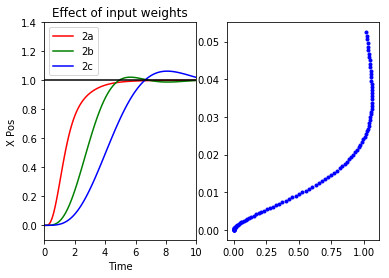

In [0]:
xs_2a, ts_2a = ctrl.step(sys_2a, T=np.linspace(0, 10, 100))
xs_2b, ts_2b = ctrl.step(sys_2b, T=np.linspace(0, 10, 100))
xs_2c, ts_2c_x = ctrl.step(sys_2c_x, T=np.linspace(0, 10, 100))
ys_2c, ts_2c_y = ctrl.step(sys_2c_y, T=np.linspace(0, 10, 100))

plt.subplot(121)
plt.title("Effect of input weights")
plt.plot(ts_2a.T, xs_2a.T, 'r-',label='2a')
plt.plot(ts_2b.T, xs_2b.T, 'g-',label='2b')
plt.plot(ts_2c_x.T, xs_2c.T, 'b-',label='2c')
plt.plot([0, 10], [1, 1], 'k-')
plt.ylabel("X Pos")
plt.xlabel("Time")
plt.legend()
plt.axis([0, 10, -0.1, 1.4]);

plt.subplot(122)
plt.plot(xs_2c.T, ys_2c.T,'b.')


In [0]:
# LQR design 3
#
# Physically motivated weighting
#
# Shoot for 1 cm error in x, 10 cm error in y.  Try to keep the angle
# less than 5 degrees in making the adjustments.  Penalize side forces
# due to loss in efficiency.
#

Qx3 = np.diag([1, 1, np.pi/5*180, 0, 0, 0])
Qu3 = 0.1*np.diag([100, 1])
(K, X, E) = ctrl.lqr(A, B, Qx3, Qu3)
K_3 = np.matrix(K)

print("State space cost:\n", Qx3)
print("Control space cost:\n", Qu3)
print("Calculated gain:\n", K)

State space cost:
 [[  1.           0.           0.           0.           0.
    0.        ]
 [  0.           1.           0.           0.           0.
    0.        ]
 [  0.           0.         113.09733553   0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]]
Control space cost:
 [[10.   0. ]
 [ 0.   0.1]]
Calculated gain:
 [[-3.16227766e-01 -5.23435434e-16  5.06914927e+00 -5.66510812e-01
  -1.46584645e-17  1.41280126e+00]
 [ 6.66832953e-16  3.16227766e+00 -1.25260531e-15  1.14021773e-15
   4.97998223e+00 -1.23788049e-16]]


Text(0, 0.5, 'Y pos')

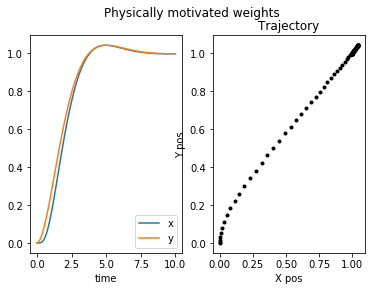

In [0]:
sys_3_x = ctrl.ss(Ax - Bx*K_3[0, lat], Bx*K_3[0, lat]*xd[lat, :], Cx, Dx)
sys_3_y = ctrl.ss(Ay - By*K_3[1, alt], By*K_3[1, alt]*yd[alt, :], Cy, Dy)

plt.subplot(121)
[xs_3, ts_3_x] = ctrl.step(sys_3_x, T=np.linspace(0, 10, 100))
[ys_3, ts_3_y] = ctrl.step(sys_3_y, T=np.linspace(0, 10, 100))
plt.plot(ts_3_x.T, xs_3.T, ts_3_y.T, ys_3.T)
plt.suptitle("Physically motivated weights")
plt.xlabel('time')
plt.legend(('x', 'y'), loc='lower right')

plt.subplot(122);
plt.plot(xs_3, ys_3, 'k.')
plt.title("Trajectory")
plt.xlabel("X pos")
plt.ylabel("Y pos")


## And lot's more!
For more information on robustness against noise and system deviations as well as frequency-domain treatment, and optimization, check out these outstanding [video lectures by Steven Brunton](https://www.youtube.com/watch?v=Pi7l8mMjYVE&list=PLMrJAkhIeNNR20Mz-VpzgfQs5zrYi085m&index=1)